In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive
from sklearn.model_selection import train_test_split

### Data Processing

In [11]:
scaler = StandardScaler()
df = pd.read_pickle('../pickle/df.pkl')

In [12]:
df_sampled = df.sample(1200,random_state=47)

In [13]:
df_features = df_sampled.iloc[:,:-1].copy()
df_target = df_sampled.iloc[:,-1].copy()

In [14]:
df_features = scaler.fit_transform(df_features)

In [15]:
df_train_features, df_test_features,df_train_target, df_test_target =  train_test_split(df_features,df_target,stratify=df_target,random_state=47, test_size=1/6)

In [17]:
df_train_target = df_train_target.to_numpy()
df_test_target = df_test_target.to_numpy()

In [18]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
# N_val = df_val_features.shape[0]
n_cat = 11 
degF=4
tau=1

### Ancestral Sampling 

In [67]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [68]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [-0.39571403 -0.01504656  1.49620266  2.18520321 -1.07839251 -0.26767323
 -0.17295402  1.75425971  0.46015743 -0.94126473  0.77581824  0.24232987
  0.48497611 -0.3754991 ]


In [69]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))


In [70]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({2.0: 79,
         6.0: 70,
         0.0: 98,
         8.0: 90,
         5.0: 44,
         7.0: 39,
         1.0: 78,
         3.0: 165,
         9.0: 120,
         4.0: 85,
         10.0: 132})

In [71]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.099


In [72]:
df_train_features.shape

(1000, 14)

### Model implementation with Pyro

In [73]:
def model(X, n_cat, degF, tau, obs=None):
    
    input_dim = X.shape[1]
    
    mu_beta = pyro.sample("mu_beta", dist.StudentT(df=torch.ones(n_cat)*degF, 
                                                    loc=torch.zeros(n_cat), 
                                                    scale=torch.ones(n_cat)).to_event()) # Prior for the bias mean      
    
    with pyro.plate("ARD", input_dim):

        sigma_beta  = pyro.sample("sigma_beta",  dist.HalfCauchy(tau*torch.ones(n_cat)).to_event()) # Prior for the bias standard deviation
        
    beta  = pyro.sample("beta", dist.Normal(mu_beta*torch.ones(n_cat), 
                                            sigma_beta).to_event()) # Priors for the regression coefficents

    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [74]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Final Model training 

In [75]:
degF=4
tau=1

In [76]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 15000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, degF, tau, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 4635.2
[1000] ELBO: 2114.3
[2000] ELBO: 1804.0
[3000] ELBO: 1738.6
[4000] ELBO: 1720.4
[5000] ELBO: 1726.2
[6000] ELBO: 1687.8
[7000] ELBO: 1737.0
[8000] ELBO: 1701.7
[9000] ELBO: 1706.3
[10000] ELBO: 1697.6
[11000] ELBO: 1709.9
[12000] ELBO: 1687.7
[13000] ELBO: 1712.0
[14000] ELBO: 1674.7


In [77]:
predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, degF, tau, y_train)

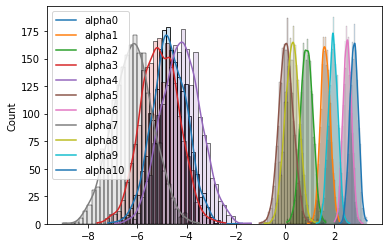

In [78]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

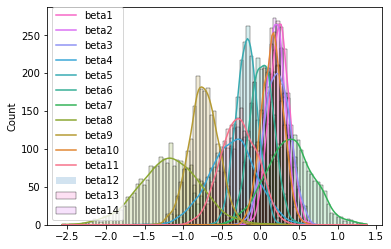

In [79]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [80]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

mean_alpha = samples_alpha.mean(axis=0)
mean_alpha = mean_alpha.T

### Inference and computation of accuracy on the train dataset 

In [81]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [82]:
y_train_pred = y_train_pred[:,0]

In [83]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.515


### Inference and computation of accuracy on the test dataset 

In [84]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([mean_alpha[i]+(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli


In [85]:
y_test_pred = y_test_pred[:,0]

In [86]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.46



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 
* Consider different distributions for priors

Done

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Train model on more data - currently 100 

TODO

* Feature engineer name and album name and retrain logistic regression model using these attributes
* Hyper parameter tuning
* Extend it with FFNN 
* Train model on more data (like 10000)